In [42]:
import numpy                as np
from os                     import listdir
import matplotlib.pyplot    as plt
import matplotlib           as mpl
import matplotlib.lines     as mlines
from natsort                import natsorted
import os
import json

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/STER/silkem/ChemTorch/')
import modclass
import src.rates as rate

def makeOutputDir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path

## get species
specs, parnt, convs = rate.read_specs_file('C', 16)

specs_dict = dict()
idx_specs  = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i
    idx_specs[i] = specs[i]

def get_time(dt, idx):
    t = np.zeros(len(dt))
    t[0] = CSEmodel.time[idx]
    for i in range(0,len(t)-1):
        t[i+1] = (dt[i]+t[i])
        
    return np.array(t)

### ChemTorch - scipy ODE solver

In [12]:

here = os.path.abspath(os.getcwd())
outpath = '/STER/silkem/ChemTorch/out/'
## scipy implementation
# dirname = 'bm_C_Mdot1e-6_v15'
dirname = 'bm_C_Mdot1e-8_v2-5'
# dirname = 'bm_C_Mdot1e-5_v20'

## load 0D model dirs
dirs = listdir(outpath+dirname+'/')
dirs.remove('meta.json')
dirs = natsorted(dirs)

## load meta file
with open(outpath+dirname+'/meta.json', 'r') as f:
    meta=f.read()

meta = json.loads(meta)

In [13]:
meta

{'1Dmodel': '/STER/silkem/CSEchem/20210518_gridC_Mdot1e-8_v02_T_epsmodel_2022-12-24h23-19-06',
 '1Dnoshield': '/STER/silkem/CSEchem/20210518_gridC_Mdot1e-8_v02_T_epsmodel_2023-11-16h16-39-55',
 'Mdot': 1e-08,
 'v': 250000.0,
 'eps': 0.6,
 'T_star': 2500.0,
 'solvertype': 'scipy'}

In [9]:
abs = []
p = []
dt = []
solver_time = []
overhead = []

for i in range(len(dirs)):
    chem = modclass.ChemTorchMod(dirname, dirs[i])
    abs.append(chem.n.T[-1])
    dt.append(chem.tstep[-1])
    p.append(chem.p)
    solver_time.append(chem.tictoc[0])
    overhead.append(chem.tictoc[1])

abs = np.array(abs)
p = np.array(p)
dt = np.array(dt)
solver_time = np.array(solver_time)
overhead = np.array(overhead)

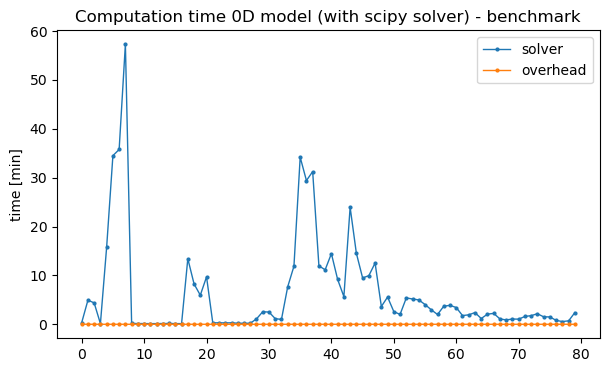

In [5]:
fig, ax1 = plt.subplots(figsize = (7,4)) 
ax1.set_title('Computation time 0D model (with scipy solver) - benchmark')

ax1.plot(solver_time /60., '-o',ms = 2,lw = 1, label = 'solver')
ax1.plot(overhead /60.  , '-o',ms = 2,lw = 1, label = 'overhead')

ax1.set_ylabel('time [min]')

plt.legend()

makeOutputDir(here+'/'+dirname)
plt.savefig(here+'/'+dirname+'/computation_time')

plt.show()

### 1D CSE model

In [14]:
CSEmodel = modclass.CSEmod(loc = 'STER', dir = meta['1Dnoshield'][21:-25], modelname = meta['1Dnoshield'][-25:])

In [82]:
CSEmodel.v/100000.0, CSEmodel.Mdot

(20.0, 1e-05)

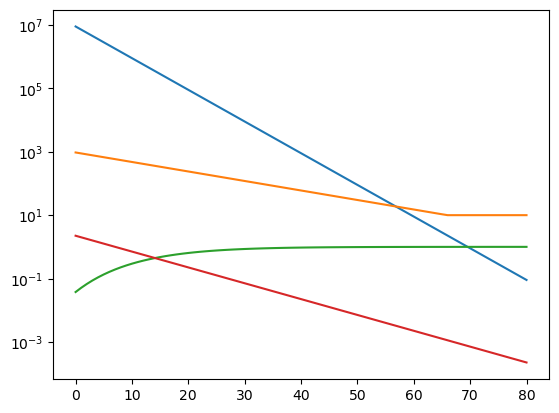

In [15]:
p = np.array(p)

# plt.plot(p)

plt.plot(CSEmodel.dens)
plt.plot(CSEmodel.temp)
plt.plot(CSEmodel.delta)
plt.plot(CSEmodel.Av)

plt.yscale('log')


plt.show()

### ChemTorch - torch ode solver

In [39]:
## torchode implementation
dirname_torch = 'bm_C_Mdot1e-8_v2-5_partial'
dirs_torch = listdir(outpath+dirname_torch+'/')
dirs_torch.remove('meta.json')
dirs_torch = natsorted(dirs_torch)

## load meta file
with open(outpath+dirname_torch+'/meta.json', 'r') as f:
    meta_torch=f.read()

meta_torch = json.loads(meta_torch)

In [40]:
meta_torch

{'1Dmodel': '/STER/silkem/CSEchem/20210518_gridC_Mdot1e-8_v02_T_epsmodel_2022-12-24h23-19-06',
 'Mdot': 1e-08,
 'v': 250000.0,
 'eps': 0.6,
 'T_star': 2500.0,
 'solvertype': 'torch'}

In [17]:
abs_t = []
p_t = []
dt_t = []
solver_time_t = []
overhead_t = []

for i in range(len(dirs_torch)):
    chem = modclass.ChemTorchMod(dirname_torch, dirs_torch[i])
    abs_t.append(chem.n.T[-1])
    dt_t.append(chem.tstep[-1])
    p_t.append(chem.p)
    solver_time_t.append(chem.tictoc[0])
    overhead_t.append(chem.tictoc[1])

abs_t = np.array(abs_t)
p_t = np.array(p_t)
dt_t = np.array(dt_t)
solver_time_t = np.array(solver_time_t)
overhead_t = np.array(overhead_t)

In [36]:
dt_t

array([597416.45137072, 597416.45137119, 597416.45137072, ...,
       597416.45137072, 597416.45137119, 597416.45137072])

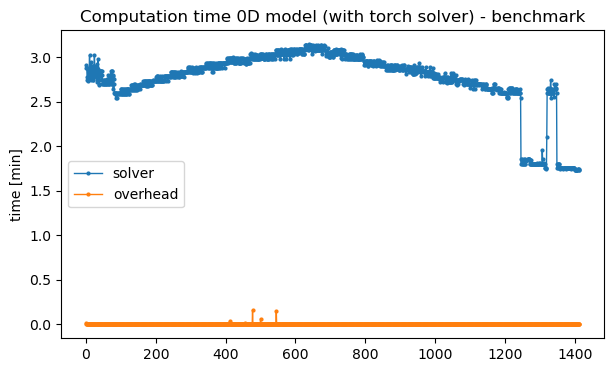

In [18]:
fig, ax1 = plt.subplots(figsize = (7,4)) 
ax1.set_title('Computation time 0D model (with torch solver) - benchmark')

ax1.plot(solver_time_t * 1./60., '-o',ms = 2,lw = 1, label = 'solver')
ax1.plot(overhead_t * 1./60.  , '-o',ms = 2,lw = 1, label = 'overhead')

ax1.set_ylabel('time [min]')

plt.legend()
plt.show()

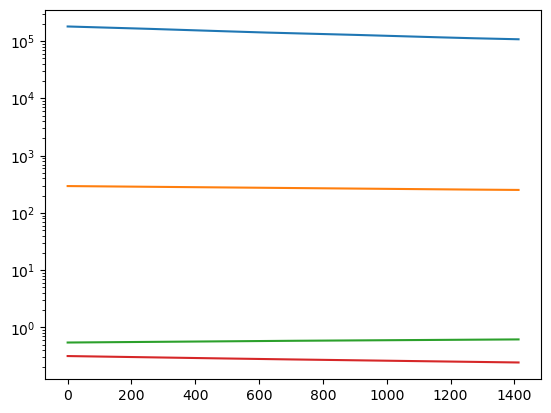

In [19]:

plt.plot(p_t)

plt.yscale('log')

plt.show()

## Plotting the benchmark

In [43]:
timearr = get_time(dt,0)
timearr_t = get_time(dt_t, 18)

In [45]:
timearr_t

array([3.17720000e+09, 3.17779742e+09, 3.17839483e+09, ...,
       4.02015461e+09, 4.02075203e+09, 4.02134945e+09])

In [69]:
timearr[17]/1e9, p[17]

(3.1772, array([1.799e+05, 2.941e+02, 5.457e-01, 3.167e-01]))

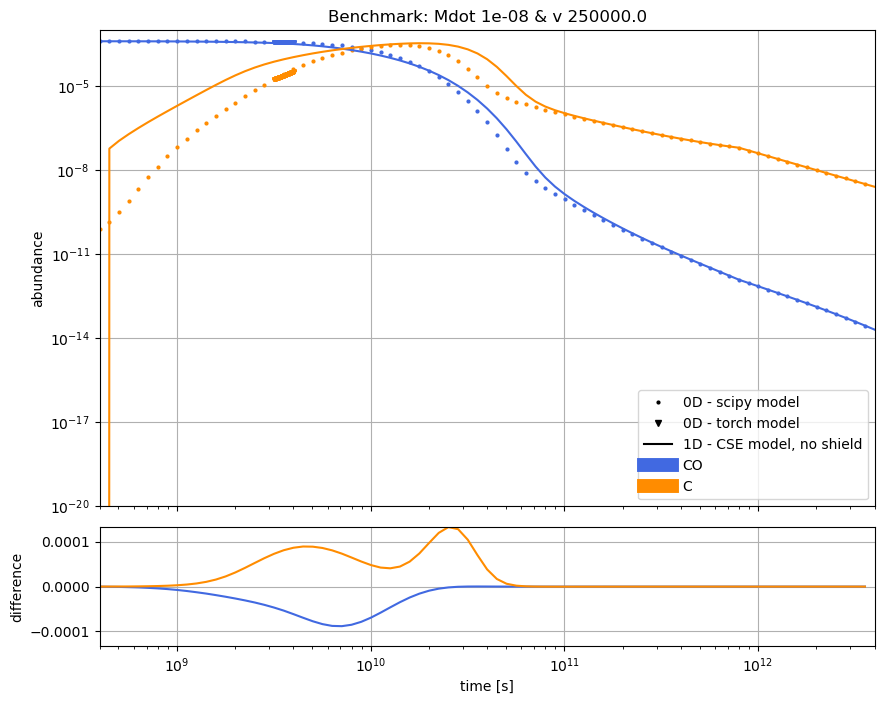

In [56]:
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,1]},figsize=(10, 8))
ax1 = axs[0]
ax2 = axs[1]

# par = 'C2H2'
# dau = 'C2H'

# par = 'H2O'
# dau = 'OH'

# par = 'HCN'
# dau = 'CN'

par = 'CO'
dau = 'C'

i = specs_dict[par]
j = specs_dict[dau]

c1 = 'royalblue'
c2 = 'darkorange'

lw = 10
ms = 2

## legend setup
l_par = mlines.Line2D([],[], color = c1, ls = '-'    , label=par,lw = lw, alpha = 1)
l_dau = mlines.Line2D([],[], color = c2, ls = '-'    , label=dau,lw = lw, alpha = 1)
l_1D  = mlines.Line2D([],[], color = 'k', ls = '-'   , label='1D - CSE model, no shield')
l_0D  = mlines.Line2D([],[], color = 'k', ls = 'none', label='0D - scipy model', marker = 'o' ,  markersize = ms)
l_0D_t= mlines.Line2D([],[], color = 'k', ls = 'none', label='0D - torch model', marker = 'v' ,  markersize = ms+2)
handles = [l_0D,l_0D_t, l_1D, l_par, l_dau]


ax1.set_title('Benchmark: Mdot '+str(meta['Mdot'])+' & v '+str(meta['v']))

## 0D ChemPy 
ax1.plot(timearr,abs.T[i], 'o', ms=ms, label = '0Dscipy', c= c1)
ax1.plot(timearr,abs.T[j], 'o', ms=ms, label = '0Dscipy', c= c2)

## 0D ChemTorch
ax1.plot(timearr_t,abs_t.T[i], 'v', ms=ms, label = '0Dtorch', c= c1)
ax1.plot(timearr_t,abs_t.T[j], 'v', ms=ms, label = '0Dtorch', c= c2)

## 1D CSE model
ax1.plot(CSEmodel.time,CSEmodel.n.T[i], '-', label = '1D', c= c1)
ax1.plot(CSEmodel.time,CSEmodel.n.T[j], '-', label = '1D' ,c= c2)

ax2.plot(timearr, (CSEmodel.n.T[i][1:]-abs.T[i]),color = c1)
ax2.plot(timearr, (CSEmodel.n.T[j][1:]-abs.T[j]),color = c2)

max_diff = max([max(np.abs(CSEmodel.n.T[i][1:]-abs.T[i])),max(np.abs(CSEmodel.n.T[j][1:]-abs.T[j]))])

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim([4e8,4e12])
    ax.grid(True)
ax1.set_yscale('log')
ax1.set_ylim([1e-20,1e-3])
ax2.set_ylim([-max_diff,max_diff])
ax2.set_xlabel('time [s]')
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel('abundance')
ax2.set_ylabel('difference')

ax1.legend(handles=handles)


plt.subplots_adjust(hspace = 0.07)
makeOutputDir(here+'/'+dirname)
plt.savefig(here+'/'+dirname+'/benchmark_'+par+'_'+dau+'_noshield')